# Citi-Bike Project
## Model
**Goal:** for each station (for each hour of the day) we want to calculate the optimal number of docks so that a customer will be able to find an empty spot 95% of the time.<br>
To calculate this, we will model the problem using an Eralng loss system where $P_m$ is the probability of finding the station full.  The formula for $P_m$ is given by:<br><br>
$min: m$<br>
$s.t.:\;P_m \leq.05$<br>
$where\;\; P_m = \frac{(\frac{\lambda}{\mu})^m/m!}{\sum_{i=0}^m(\frac{\lambda}{\mu})^i/i!}$
$Integer:\; m$<br>

**Estimation from data** In order to use this model we will need to estimate lambda (the arrival rate) and mu (the service rate).  We do this from data by simply counting the amount or arrivals/departures for an hour -- i.e. Moday from 8:00 am to 9:00 am there were 10 arrivals and 30 departures for dock A.  Then we take the average for these times over the most recent month.

In [1]:
import pandas as pd
citi_month = pd.read_csv("201609-citibike-tripdata.csv")
print(citi_month.head())
station_df = pd.DataFrame({'station': citi_month['start station id'],'lat': citi_month['start station latitude'],'long':citi_month['start station longitude']}).drop_duplicates(['station'])


   tripduration          starttime           stoptime  start station id  \
0           975  9/1/2016 00:00:02  9/1/2016 00:16:18               312   
1          1220  9/1/2016 00:00:04  9/1/2016 00:20:25               316   
2           308  9/1/2016 00:00:19  9/1/2016 00:05:27               479   
3           250  9/1/2016 00:00:25  9/1/2016 00:04:35               297   
4           439  9/1/2016 00:00:25  9/1/2016 00:07:45               494   

       start station name  start station latitude  start station longitude  \
0   Allen St & Stanton St               40.722055               -73.989111   
1  Fulton St & William St               40.709560               -74.006536   
2         9 Ave & W 45 St               40.760193               -73.991255   
3         E 15 St & 3 Ave               40.734232               -73.986923   
4         W 26 St & 8 Ave               40.747348               -73.997236   

   end station id           end station name  end station latitude  \
0         

In [15]:
#print(station_df[station_df['lat']<40.45])
#citi_month[citi_month['end station id']==160]
#station 160 is in a wrong location!
print("station", station_df.ix[716308:716308+1])
station_df.set_value(716308, 'lat', 40.74)
print(station_df[station_df['station']==160])

station           lat       long  station  label
716308  40.74 -73.978238      160     87
          lat       long  station  label
716308  40.74 -73.978238      160     87


## Clustering
**A deflated arrival rate** We were worried that true arrival rates would be deflated because some customers are going to the location and finding it already full. To reduce this arrival rate deflation, we are modeling on a cluster basis -- we are using the arrival rate and service rates of a cluster of locations.

In [16]:
#Cluster the 328 unique stations using station_df lat and long columns
from scipy.cluster.vq import whiten, kmeans2

#want about 4 locations per cluster
clusters = len(station_df.station) // 4 #82 clusters
print(clusters)
w = whiten(station_df[['lat','long']]) #standardize features
centroid, label = kmeans2(station_df[['lat','long']],clusters) 
station_df['label'] = label

#Save the cluster labels per station
station_df.to_csv('cluster_labels.csv')

154


/Users/aslakey/anaconda/lib/python3.5/site-packages/scipy/cluster/vq.py:659: UserWarning: One of the clusters is empty. Re-run kmean with a different initialization.
  warnings.warn("One of the clusters is empty. "


Number of clusters 123
max number of stations per cluster 13     15
76     15
78     14
127    11
45     11
Name: label, dtype: int64


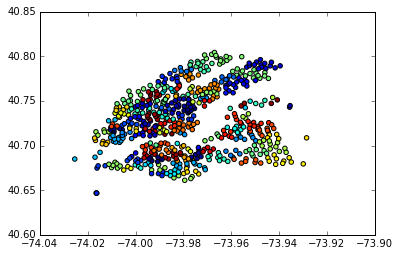

In [17]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#how many clusters/how many per cluster?
print("Number of clusters",len(pd.value_counts(station_df.label)))
print("max number of stations per cluster",pd.value_counts(station_df.label).head()) #ok most clusters have less then 7 stations.  Some have up to 16 though

#visualize the clusters
plt.scatter(station_df.long, station_df.lat, c=station_df.label)
plt.show()

## Calculating Arrival and Departure Rates

Merge Cluster output with monthly citibike data.  MLE for cluster arrival rate, $\lambda$, is the average hourly count of arrivals.  MLE for cluster service rate, $\mu$, is also the average hourly count, but this time for departures.  Thus the mean service time = $1/\mu$

In [18]:
start_df = citi_month.merge(station_df[['station','label']], left_on='start station id', right_on='station', how='outer')
full_df = start_df.merge(station_df[['station','label']], left_on='end station id', right_on='station', how='outer',suffixes=['_start',"_end"])
full_df.keys()
#release some memory 
lst = [citi_month, start_df]
del lst 
full_df.keys()

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'station_start', 'label_start', 'station_end',
       'label_end'],
      dtype='object')

In [19]:
import datetime
#create hours and days of the week
full_df['starttime'] = pd.to_datetime(full_df['starttime'],infer_datetime_format=True)
full_df['stoptime'] = pd.to_datetime(full_df['stoptime'],infer_datetime_format=True)
full_df['start_date'] = full_df['starttime'].dt.date
full_df['start_day'] = full_df['starttime'].dt.dayofweek
full_df['start_hour'] = full_df['starttime'].dt.hour
full_df['end_date'] = full_df['stoptime'].dt.date
full_df['end_day'] = full_df['stoptime'].dt.dayofweek
full_df['end_hour'] = full_df['stoptime'].dt.hour
#select hours 7 through 20
full_df = full_df.loc[(full_df.start_hour>6)&(full_df.start_hour<21)&(full_df.end_hour<21)]

#Now groupby's to calculate rates
#rate = (count(cluster,day,hour).date) / unique((cluster,day,hour).date)
service_df = full_df.groupby(['label_start','start_day','start_hour']).start_date.count()/full_df.groupby(['label_start','start_day','start_hour']).start_date.nunique()
arrival_df = full_df.groupby(['label_end','end_day','end_hour']).end_date.count()/full_df.groupby(['label_end','end_day','end_hour']).end_date.nunique()

In [20]:
#for each label, for each day of the week, for each hour we have a service and arrival rate
arrival_df = arrival_df.to_frame()
service_df = service_df.to_frame()
#service_rate.keys() #of so this is slightly confusing, but now we have what we want.  A multi-level indexed data frame
#servcice_rate[label][day][hour]

In [21]:
#Merge service and arrival data frames
service_df.index.levels[0].name = "cluster"
service_df.index.levels[1].name = 'day'
service_df.index.levels[2].name = 'hour'
arrival_df.index.levels[0].name = 'cluster'
arrival_df.index.levels[1].name = 'day'
arrival_df.index.levels[2].name = 'hour'
cluster_rates = pd.merge(service_df, arrival_df, left_index=True, right_index=True, how='outer')

cluster_rates.rename(columns={"start_date": "ServiceRate", "end_date": "ArrivalRate"}, inplace=True)
#*ASSUMPTION* That if there are any NA values, at least one person will come 
cluster_rates.fillna(value=1, inplace = True) 
cluster_rates['rho'] = cluster_rates.ArrivalRate/cluster_rates.ServiceRate
cluster_rates

ServiceRate  ArrivalRate       rho
cluster day hour                                    
0.0     0.0 7.0         44.75    43.250000  0.966480
            8.0         85.50    58.000000  0.678363
            9.0         48.00    32.500000  0.677083
            10.0        29.50    19.000000  0.644068
            11.0        24.50    16.250000  0.663265
            12.0        28.00    30.000000  1.071429
            13.0        33.25    37.250000  1.120301
            14.0        43.00    29.500000  0.686047
            15.0        42.50    32.500000  0.764706
            16.0        39.00    31.500000  0.807692
            17.0        54.50    61.750000  1.133028
            18.0        61.00    71.500000  1.172131
            19.0        61.00    62.250000  1.020492
            20.0        39.50    40.250000  1.018987
        1.0 7.0         71.25    58.500000  0.821053
            8.0        144.25    94.750000  0.656846
            9.0         73.00    53.250000  0.729452
            10.0        38.50    34.000000  0.883117
            11.0        26.75    27.000000  1.009346
            12.0        28.75    27.500000  0.956522
            13.0        39.75    37.250000  0.937107
            14.0        36.25    33.750000  0.931034
            15.0        40.00    33.500000  0.837500
            16.0        43.25    40.500000  0.936416
            17.0        55.00    69.250000  1.259091
            18.0        69.50    81.500000  1.172662
            19.0        57.50    65.000000  1.130435
            20.0        41.50    45.750000  1.102410
        2.0 7.0         79.50    58.250000  0.732704
            8.0        140.50    92.250000  0.656584
...                       ...          ...       ...
153.0   4.0 19.0         6.00     6.800000  1.133333
            20.0         3.00     4.800000  1.600000
        5.0 7.0          5.00     2.750000  0.550000
            8.0          5.75     2.250000  0.391304
            9.0          6.75     3.333333  0.493827
            10.0         6.25     2.500000  0.400000
            11.0        12.25     6.000000  0.489796
            12.0        10.50     9.500000  0.904762
            13.0         7.50     8.750000  1.166667
            14.0        10.00     6.250000  0.625000
            15.0        10.50     8.500000  0.809524
            16.0         7.75     7.500000  0.967742
            17.0         7.75     7.250000  0.935484
            18.0         6.25     9.750000  1.560000
            19.0         4.00     8.250000  2.062500
            20.0         3.75     6.250000  1.666667
        6.0 7.0          3.00     1.666667  0.555556
            8.0          6.50     3.000000  0.461538
            9.0          7.25     1.666667  0.229885
            10.0         6.00     4.333333  0.722222
            11.0        10.50     6.500000  0.619048
            12.0         9.75     5.250000  0.538462
            13.0         6.00     4.750000  0.791667
            14.0         9.50    10.750000  1.131579
            15.0         7.75     7.000000  0.903226
            16.0         7.50     8.750000  1.166667
            17.0         4.75     8.500000  1.789474
            18.0         6.75     7.500000  1.111111
            19.0         5.75     6.000000  1.043478
            20.0         3.00     6.500000  2.166667

[12096 rows x 3 columns]

In [22]:
len(cluster_rates)
cluster_rates.isnull().sum()
#for some hours rho is giving NA, we will need to fill this in somehow!

ServiceRate    0
ArrivalRate    0
rho            0
dtype: int64

## Computing Optimal Number of Docks

We are looking for the optimal number of docks at a station to service a customer who is looking to dock a bike at 98%.  Because we are modeling this as an M/G/m queue, we can use the below formulation:
$min: m$<br>
$s.t.:\;P_m \geq.02$<br>
$Integer:\; m$<br>
$where\;\; P_m = \frac{(\frac{\lambda}{\mu})^m/m!}{\sum_{i=0}^m(\frac{\lambda}{\mu})^i/i!}$

Note, that the calculation of $P_m$ quickly becomes unstable for large m, so we can revert to the recursive formulation of $P_m$. Namely, call the probability of being blocked $B(\rho,m)$ -- with utilization rate $\rho=\lambda/\mu$ and number of servers $m$ <br>
Then we can calculate $B(\rho,m)$ the following recursive formula:
$$B(\rho,m)\;=\;\frac{\rho*B(m-1,\rho)}{m+\rho*B(m-1,\rho)}$$

In [26]:
import math

def calc_sum(m,ro):
    s = 0
    for i in range(1,m+1):
        s += ((ro)**i)/math.factorial(i)
    return (s)

def Prob_m(m,ro):
    numer = ((ro)**m)/math.factorial(m)
    divis = calc_sum(m,ro)
    return(numer/divis)

def recurB(oldB,m,rho):
    numer = rho*oldB
    div = m + rho*oldB
    return(numer/div)

'''
For each row, we will first calculate P_m(1,ro).  If this is 
already less than .02, we can stop. Otherwise, we need to recurse until we
arrive at a number of docks where P_m falls below 0.02
'''
def optimal_docks(row):
    rho = row['rho']

    prob = Prob_m(1,rho)
    #only need one empty dock here
    if  prob <= .02:
        return (1)
    else:
        #might need more, recurse
        for m in range(2,1000):
            prob = recurB(prob,m,rho)
            if prob<=0.02:
                return(m)
    return

def optimal_bikes(row):
    rho = 1/row['rho']

    prob = Prob_m(1,rho)
    #only need one empty dock here
    if  prob <= .02:
        return (1)
    else:
        #might need more, recurse
        for m in range(2,1000):
            prob = recurB(prob,m,rho)
            if prob<=0.02:
                return(m)
    return

cluster_rates['optimalDocks'] = cluster_rates.apply(optimal_docks, axis=1)
cluster_rates['optimalBikes'] = cluster_rates.apply(optimal_bikes, axis=1)

In [27]:
cluster_rates.to_csv('optimal_docks.csv')
cluster_rates.describe()

,ServiceRate,ArrivalRate,rho,optimalDocks,optimalBikes
count,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000
mean,27.957104,27.947541,1.097663,4.770420,4.889220
std,32.043242,32.563805,0.609020,0.992133,1.231445
min,1.000000,1.000000,0.073579,3.000000,3.000000
25%,6.750000,6.250000,0.789474,4.000000,4.000000
50%,16.500000,16.400000,1.000000,5.000000,5.000000
75%,38.500000,38.000000,1.262315,5.000000,5.000000
max,356.500000,436.000000,11.783784,19.000000,21.000000
